## Install package

In [1]:
pip install -q datasets

## Import package and dataset

In [2]:
import datasets
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv

--2025-05-21 19:34:37--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  51.4MB/s    in 0.3s    

2025-05-21 19:34:37 (51.4 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]



## Read dataset

In [3]:
df = pd.read_csv("data/full_dataset/goemotions_1.csv")
df.to_csv('/content/df_temp.csv',index = False)
df.shape

(70000, 37)

## Select columns we need (text and emotions)

In [4]:
selected_columns = ['text', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral']

df_selected = df[selected_columns]

## Text cleaning (Strip unwanted tokens, lowercase, remove empty or short texts)

In [5]:
###Strip unwanted tokens (e.g., [NAME], HTML tags, etc.)

def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r"\[NAME\]", "", text)              # remove [NAME]
    text = re.sub(r"<.*?>", "", text)                 # remove HTML tags
    text = re.sub(r"\s+", " ", text)                  # collapse multiple spaces
    text = re.sub(r"[^a-zA-Z0-9.,!?'\s]", "", text)   # Removes emojis, hashtags, symbols
    return text.strip()

df_selected['clean_text'] = df_selected['text'].apply(clean_text).str.lower() #Lowercase text (Optional for BERT, but helpful for consistency)

# Reorder columns: move 'clean_text' to the front
cols = ['clean_text'] + [col for col in df_selected.columns if col not in  ('clean_text','text')]
df_selected = df_selected[cols]

df_selected = df_selected[df_selected['clean_text'].str.strip() !=""] ###Remove empty or short texts
df_selected_1 = df_selected[df_selected['clean_text'].str.len() > 10] ###Remove short texts




<ipython-input-5-7cf2daca93f2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['clean_text'] = df_selected['text'].apply(clean_text).str.lower() #Lowercase text (Optional for BERT, but helpful for consistency)


##Visualization: count by each emotion

In [ ]:


emotion_stats = []
for column in selected_columns[1:]:
  count = int(df_selected_1[column].sum())
  percentage = round((count/df_selected_1.shape[0])*100,2)
  emotion_stats.append({
      "emotions":column,
      "count":count,
      "percentage":percentage
  })

emotion_stats = pd.DataFrame(emotion_stats)

###Check Class Imbalance
emotion_stats.sort_values(by='count', ascending = False)


,emotions,count,percentage
27,neutral,18010,26.15
4,approval,5875,8.53
0,admiration,5571,8.09
3,annoyance,4417,6.41
15,gratitude,3750,5.44
10,disapproval,3750,5.44
7,curiosity,3232,4.69
1,amusement,3044,4.42
20,optimism,2874,4.17
22,realization,2862,4.16


## Visualization: count by each emotion

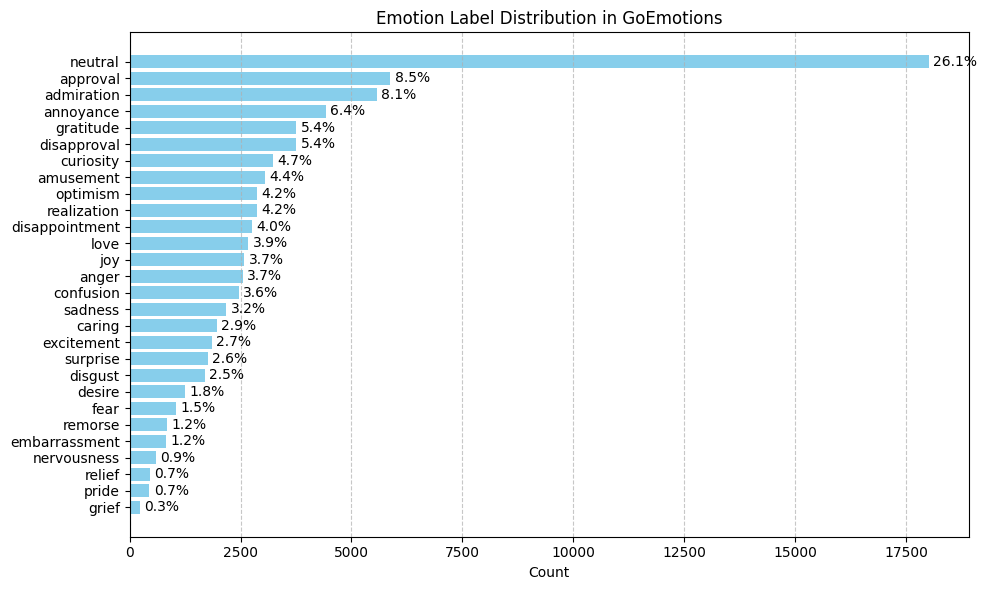

In [ ]:
###Check Class Imbalance
plt.figure(figsize = (10,6))
df_sorted = emotion_stats.sort_values(by='count', ascending=True)
bars = plt.barh(df_sorted['emotions'], df_sorted['count'], color='skyblue')


# Add percentage labels at the end of each bar
for bar, pct in zip(bars, df_sorted['percentage']):
    plt.text(bar.get_width() + 100,  # Adjust the offset as needed
             bar.get_y() + bar.get_height() / 2,
             f"{pct:.1f}%",  # Format the percentage
             va='center')



plt.xlabel("Count")
plt.title("Emotion Label Distribution in GoEmotions")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Multi-Label Frequency per Text

<ipython-input-33-a7b53e80c8ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_1["num_labels"] = df_selected_1.iloc[:, 1:].sum(axis=1)


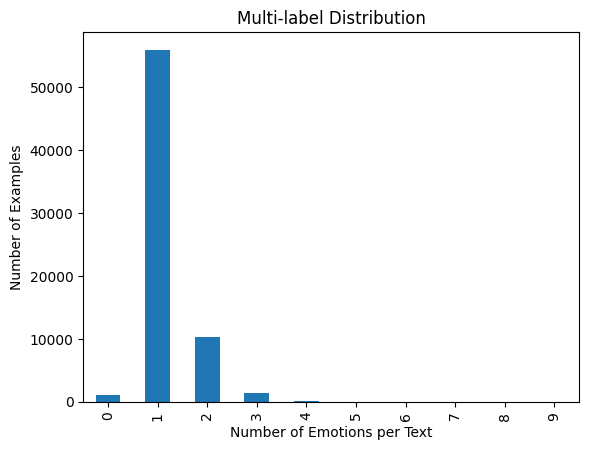

In [ ]:

df_selected_1["num_labels"] = df_selected_1.iloc[:, 1:].sum(axis=1)
df_selected_1["num_labels"].value_counts().sort_index().plot.bar()
plt.xlabel("Number of Emotions per Text")
plt.ylabel("Number of Examples")
plt.title("Multi-label Distribution")
plt.show()

## Examples by Emotion

In [ ]:

for emotion in ["joy", "anger", "sadness"]:  # adjust list
    print(f"\nExamples for {emotion}:")
    print(df_selected_1[df_selected_1[emotion] == 1]["clean_text"].head(2).to_list())



Examples for joy:
["so happy for . so sad he's not here. imagine this team with instead of . ugh.", "by far the coolest thing i've seen on this thread yet"]

Examples for anger:
['oh, how dare you discuss the disgustingly unhealthy and dangerous lifestyle i pursue! s', 'press fucken charges the moment they use your info.']

Examples for sadness:
['that game hurt.', "so happy for . so sad he's not here. imagine this team with instead of . ugh."]


In [8]:
df_selected_1.to_csv('/content/preprocessed_goemotions.csv', index = False)